In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

'''import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
'''

'import tensorflow as tf\nfrom tensorflow.keras import backend as K\nfrom tensorflow.keras.layers import *\nfrom tensorflow.keras.models import *\nfrom tensorflow.keras.callbacks import *\nfrom tensorflow.keras.optimizers import *\nfrom tensorflow.keras.preprocessing.sequence import TimeseriesGenerator\n'

In [ ]:
dataset = pd.read_excel("../input/rishikesh/dataset_compiled_rishikesh_95-2020.xlsx",parse_dates=['Date'])

In [ ]:
dataset.head()

In [ ]:
dataset.tail()

In [ ]:
dataset.info()

In [ ]:
dataset[dataset['TDS'].notnull()].head()

TDS data only available from Jun 2011 onwards

In [ ]:
dataset.describe()

Alkalinity min value 4 might be an outlier

In [ ]:
dataset.set_index('Date', inplace= True)

In [ ]:
sns.heatmap(dataset.isnull() , cmap = 'viridis' , yticklabels = False)

In [ ]:
dataset.columns  = ['pH', 'Temp', 'Alkanity', 'Ca', 'Mg', 'DO', 'BOD', 'Cl', 'TDS']

In [ ]:
dat = (dataset.isnull().sum()).sort_values(ascending= False)
Missing_Data = pd.DataFrame({'Number of missing values' : dat})
Missing_Data

In [ ]:
lis =  dataset.columns
for i in lis:
    plt.figure(figsize=(25, 10))
    plt.plot(dataset[i])
    plt.ylabel(i)
    plt.xlabel('Date')

In [ ]:
dataset.drop('TDS', inplace =True, axis= 1 )
features = ['pH', 'Temp', 'Alkanity', 'Ca', 'Mg', 'DO', 'BOD', 'Cl']    #excluding TDS from input features

In [ ]:
dataset[dataset['Mg'].isnull() & dataset['Temp'].notna()].index

Mg, Ca, Cl missing values Jun 2015 - dec 16 where temp and other values are non null

In [ ]:
#interpolating values
dataset= dataset.interpolate(method='time')

In [ ]:
lis =  features
for i in lis:
    plt.figure(figsize=(25, 10))
    plt.plot(dataset[i])
    plt.ylabel(i)
    plt.xlabel('Date')

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(dataset.corr(),annot=True, linewidths=1 ,cmap= 'viridis')

- Autocorrelations plots

In [ ]:
for i in dataset:
    plot_acf(dataset[i], lags = 50)
    plt.title('ACF for %s' % i)
    plt.show()

Stationarity Tests

- AdFuller

In [2]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary
non_stationary_ad_fuller  = []
def adfuller_test(values, i):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Time series has a unit root, indicating it is non-stationary ")
        non_stationary_ad_fuller.append(i)

In [3]:
for i in lis:
    print(i)
    adfuller_test(dataset[i],i)

NameError: name 'lis' is not defined

In [4]:
non_stationary_ad_fuller

[]

Dealing with non-stationary variables

In [5]:
dataset_differenced = dataset.diff().dropna()

NameError: name 'dataset' is not defined

In [6]:
for i in lis:
    print(i)
    adfuller_test(dataset_differenced[i],i)

NameError: name 'lis' is not defined

- All variables stationary now

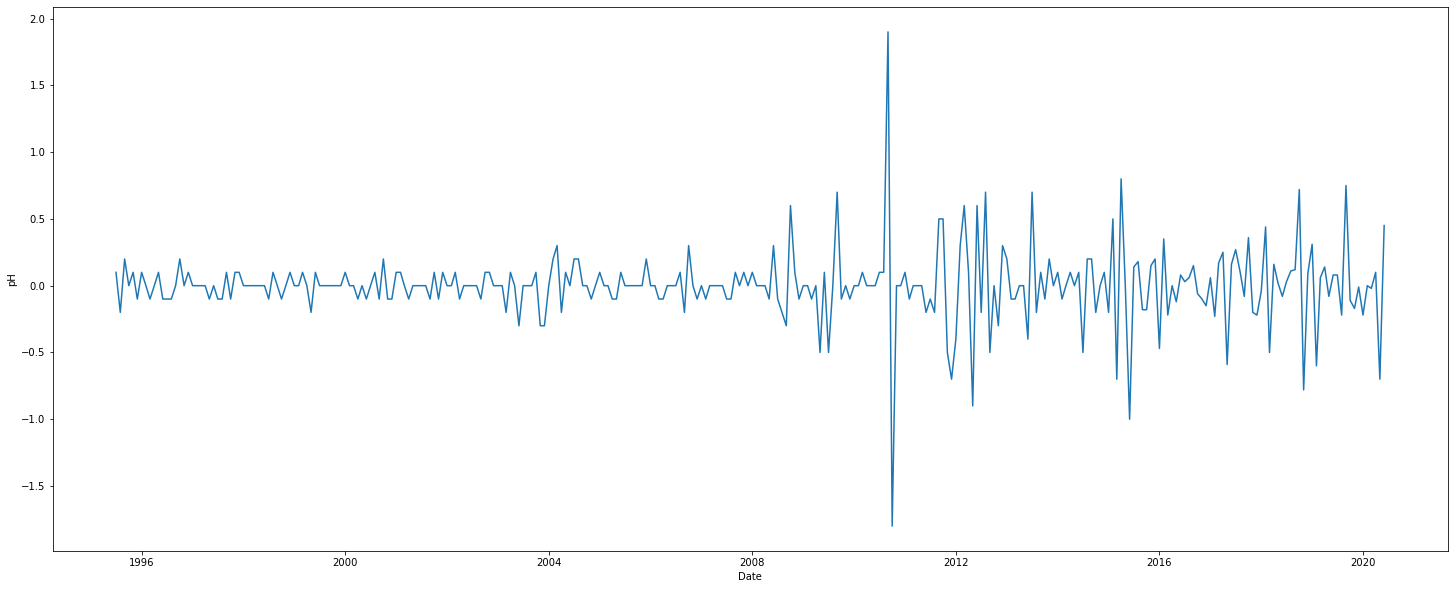

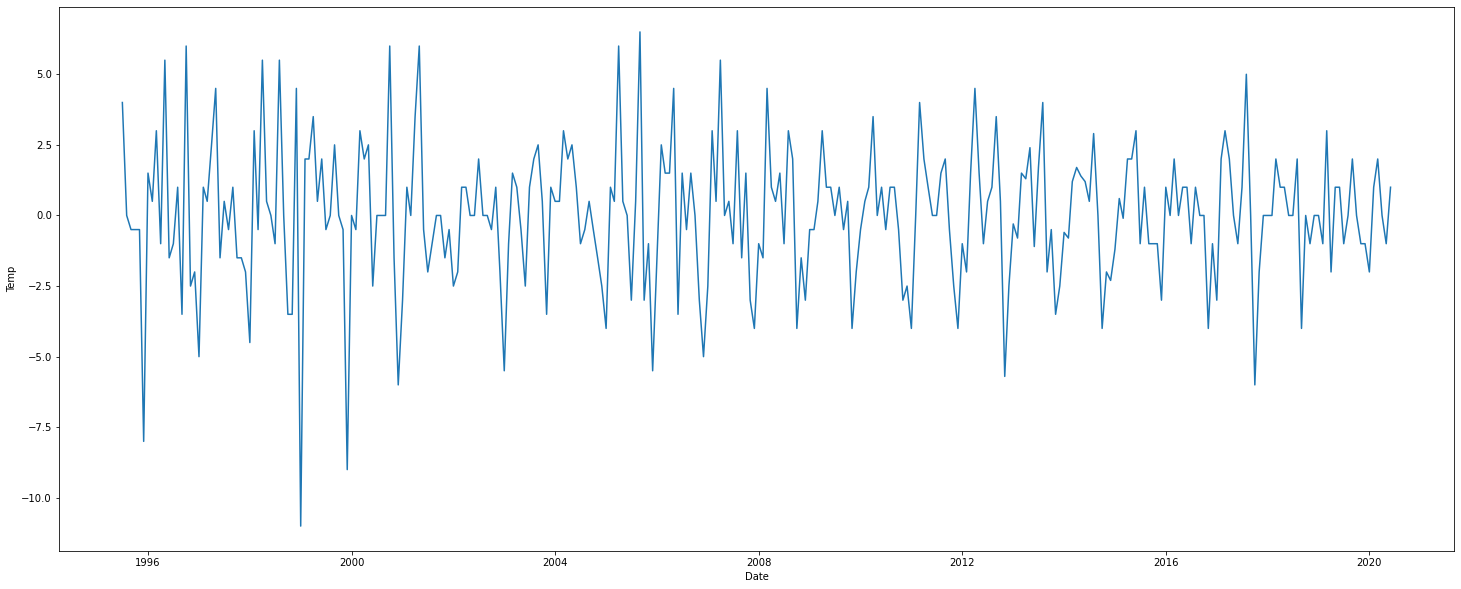

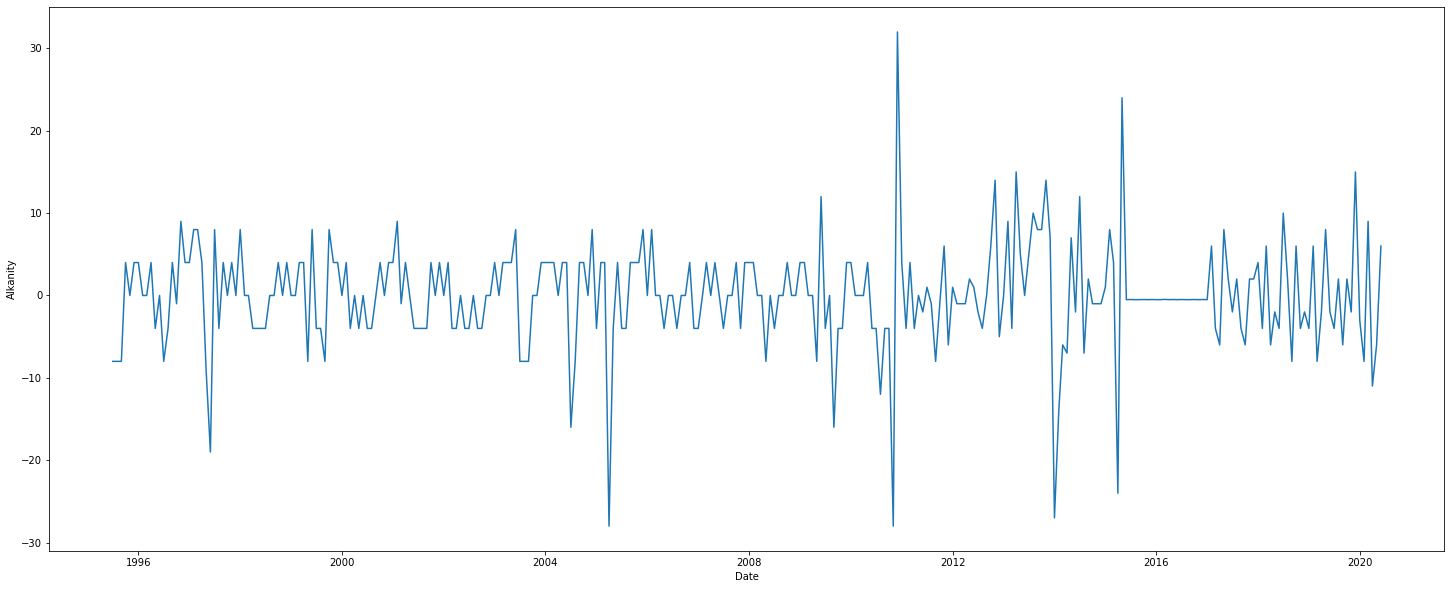

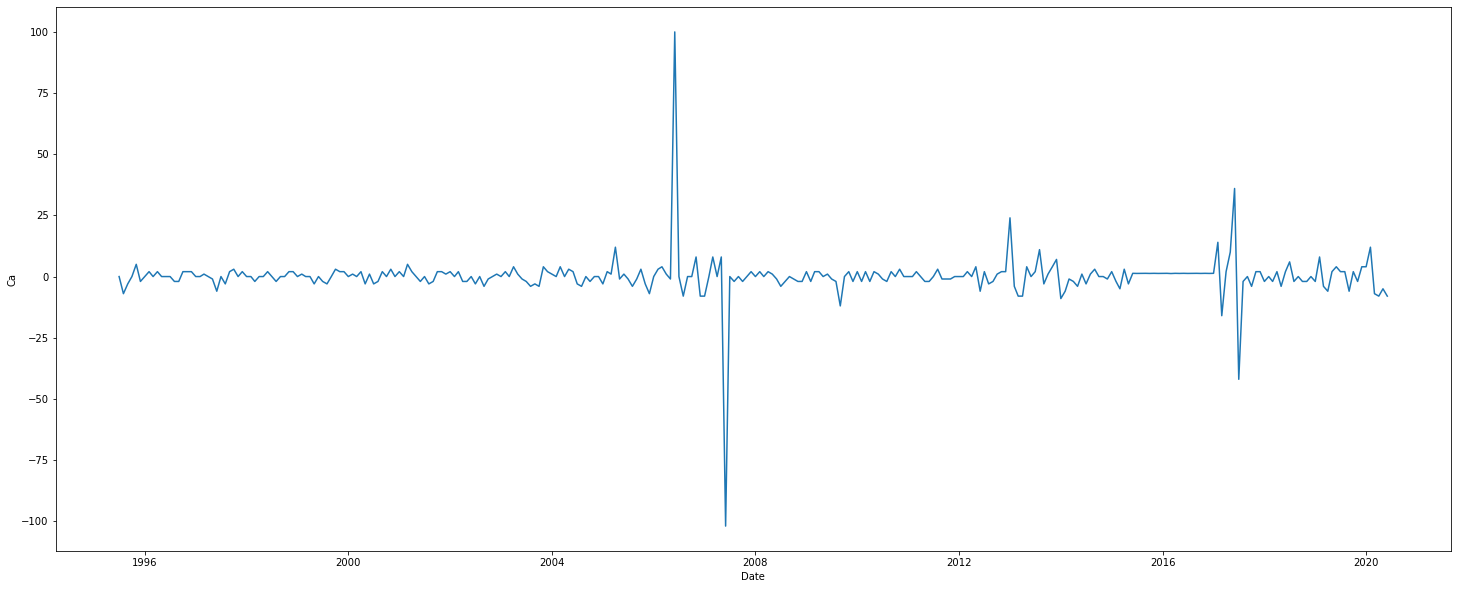

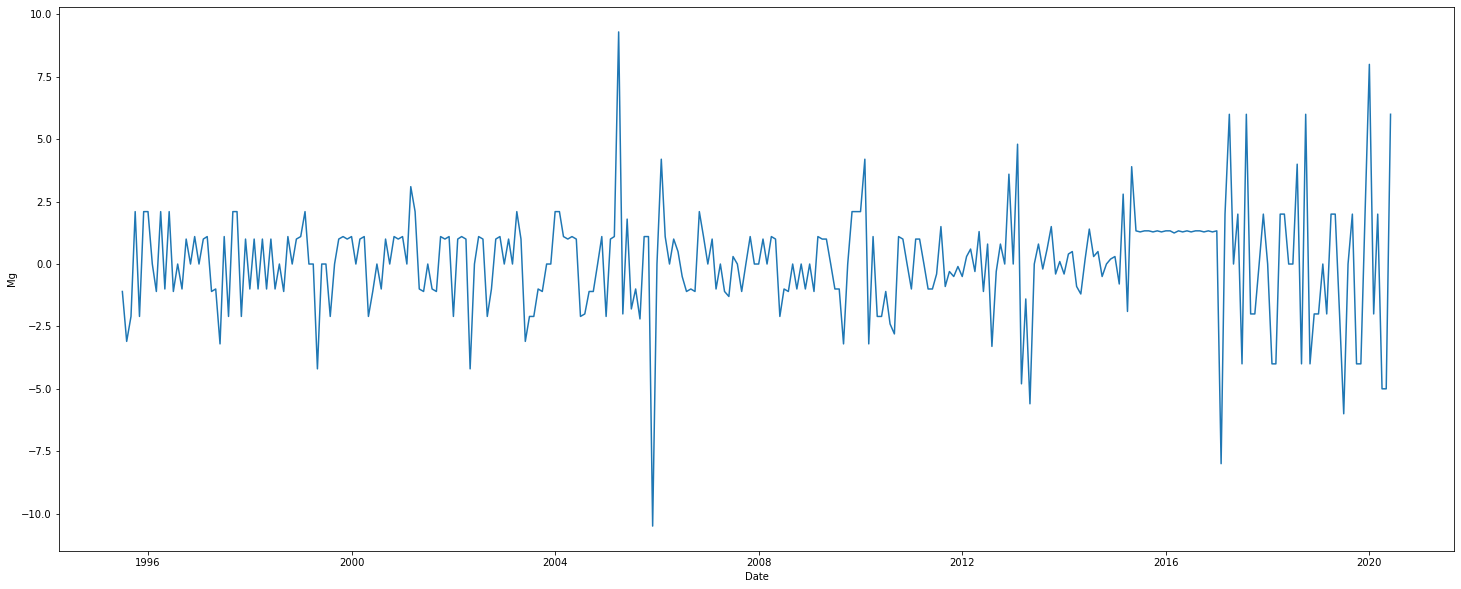

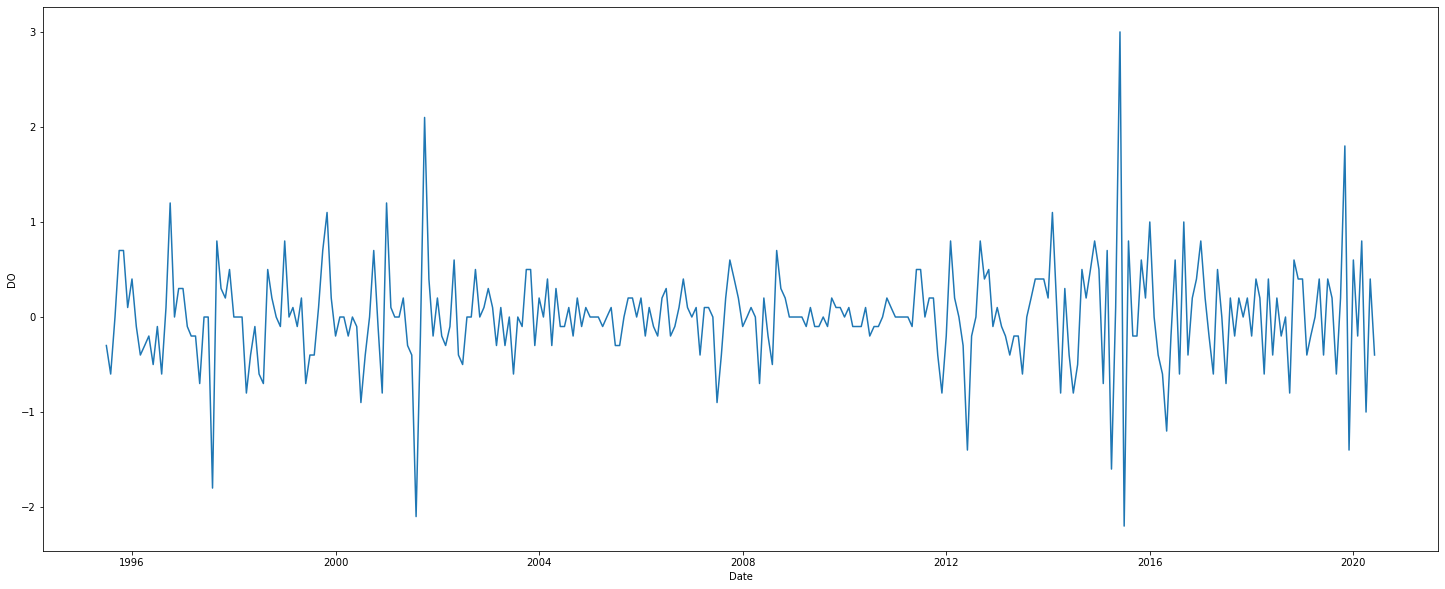

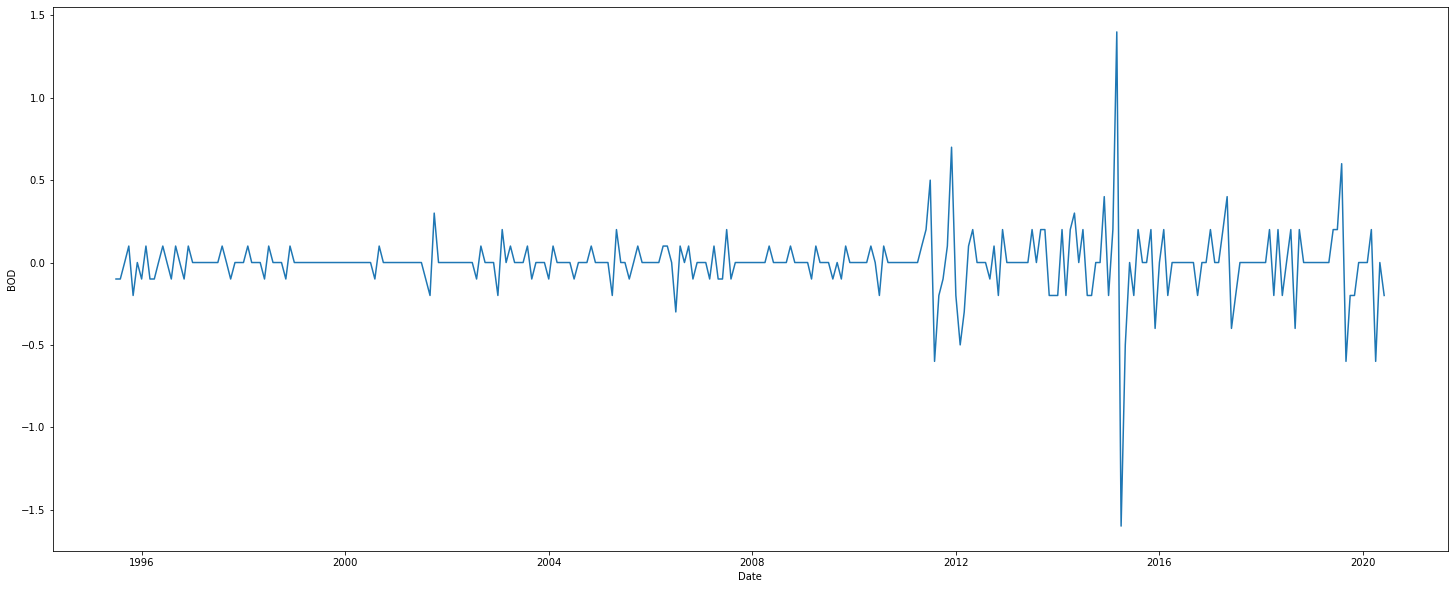

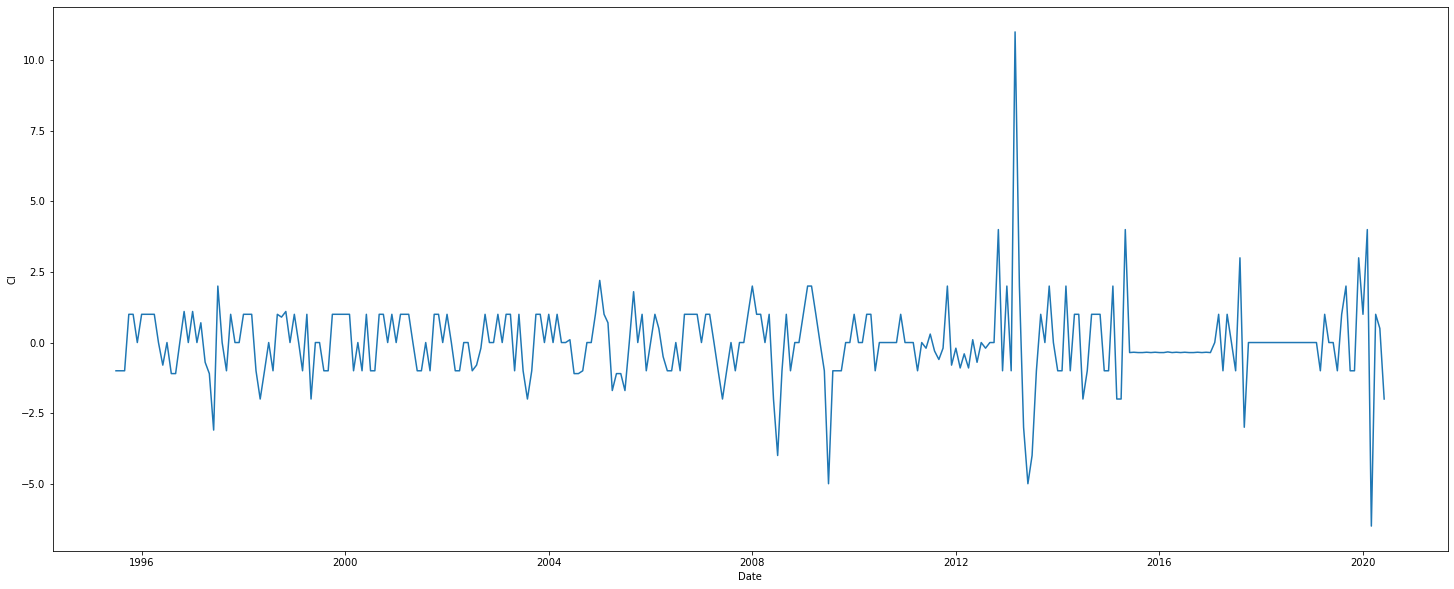

In [470]:
lis =  features
for i in lis:
    plt.figure(figsize=(25, 10))
    plt.plot(dataset_differenced[i])
    plt.ylabel(i)
    plt.xlabel('Date')

#### Checking persistent models performance

In [471]:
from math import sqrt
def persistence(train, test , label):
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # make prediction
        predictions.append(history[-1]) #persistence based on one day prior predictions
        # observation
        history.append(test[i])
     # line plot of observed vs predicted
    plt.plot(test, label = 'test')
    plt.plot(predictions , label = 'predictions')
    plt.title(label)
    plt.legend(loc = 'best')
    plt.show()
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test,predictions)
    print('RMSE: %.3f' % rmse)
    print('R2 score : %.3f' %r2)

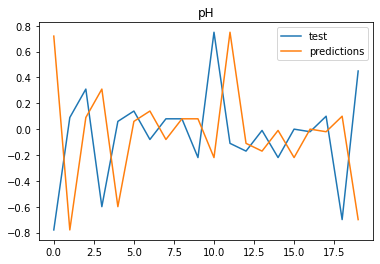

RMSE: 0.643
R2 score : -2.331


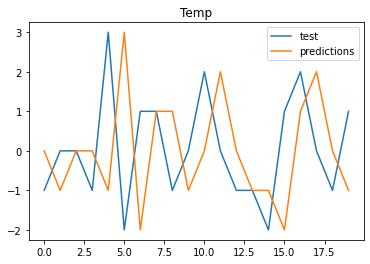

RMSE: 2.086
R2 score : -1.489


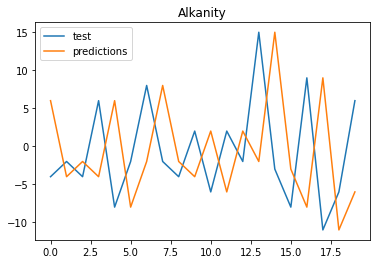

RMSE: 10.770
R2 score : -1.781


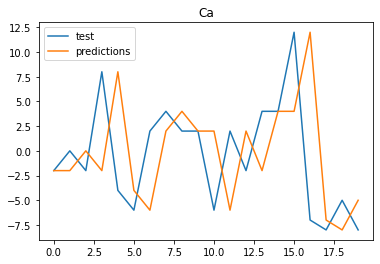

RMSE: 6.899
R2 score : -0.673


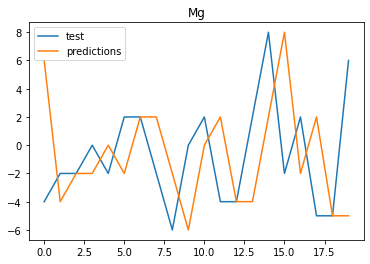

RMSE: 5.450
R2 score : -1.248


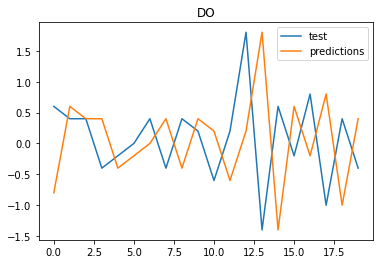

RMSE: 1.220
R2 score : -2.224


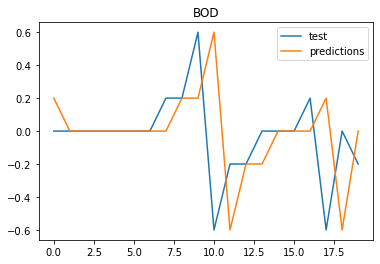

RMSE: 0.385
R2 score : -1.273


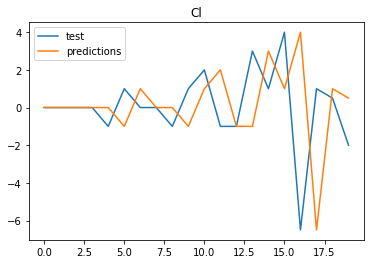

RMSE: 3.339
R2 score : -1.672


In [472]:
for i in lis:
    X = dataset_differenced[i].values
    train, test = X[:-20], X[-20:]
    persistence(train,test,i)

Note - Take inverse transform before interpreting results

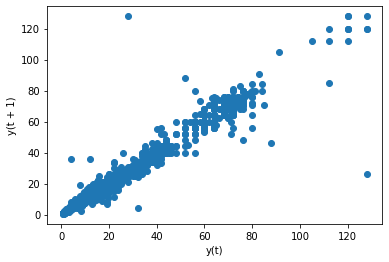

In [473]:
pd.plotting.lag_plot(dataset)

train test split

In [474]:
n_obs=20
X_train, X_test = dataset[0:-n_obs], dataset[-n_obs:]
print(X_train.shape, X_test.shape)


(281, 8) (20, 8)


In [475]:
len(dataset)

301

Applying differencing only on train data

In [476]:
transformed_data = X_train.diff().dropna()

In [477]:
#LAG order selection
model = VAR(endog=transformed_data)
res = model.select_order(30)
res.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,4.699,4.811*,109.8,4.744
1,4.614,5.628,100.9,5.022
2,4.613,6.529,100.9,5.384
3,4.536,7.353,93.80,5.670
4,4.577,8.296,98.45,6.074
5,4.730,9.350,116.0,6.589
6,4.795,10.32,126.0,7.018
7,4.965,11.39,153.0,7.550
8,5.080,12.40,177.2,8.028
9,5.139,13.36,196.1,8.449


choosing lag = 25

VAR model

In [10]:
from statsmodels.tsa.api import VAR
model = VAR(endog = transformed_data)
results = model.fit(maxlags=30, ic='aic')

NameError: name 'transformed_data' is not defined

##### Forecasting

In [479]:
lag_order = 30
# Input data for forecasting
input_data = transformed_data.values[-lag_order:]
# forecasting
pred = results.forecast(y=input_data, steps=20)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))


#### Inverse Transform 


In [480]:
# inverting transformation
def invert_transformation(X_train, pred_df):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(X_train, pred)

In [481]:
output

,pH_pred,Temp_pred,Alkanity_pred,Ca_pred,Mg_pred,DO_pred,BOD_pred,Cl_pred
Date,,,,,,,,
2018-11-01,6.644729,17.620321,27.094564,49.825905,41.993309,6.720428,1.167615,-0.306423
2018-12-01,6.058592,5.296259,-4.637126,53.584289,21.283981,6.185364,1.843449,-1.008945
2019-01-01,5.983360,22.021273,-4.365364,145.469332,26.437531,4.128434,1.505203,-2.689439
2019-02-01,5.930926,6.419925,52.890967,208.375152,32.066817,7.625872,0.817885,5.723591
2019-03-01,6.482600,12.522126,12.613711,252.754588,45.883726,6.508913,1.151828,9.493969
2019-04-01,7.853834,12.053615,39.683262,228.259488,20.495904,7.110282,0.727465,17.071003
2019-05-01,8.310804,32.311319,94.546467,189.550497,27.599785,7.210637,1.577376,21.208322
2019-06-01,8.161738,38.325934,155.587146,171.859691,45.310608,10.057627,1.026077,19.132057
2019-07-01,6.208724,22.466054,194.382020,50.830172,42.083135,12.558028,1.643070,18.239474


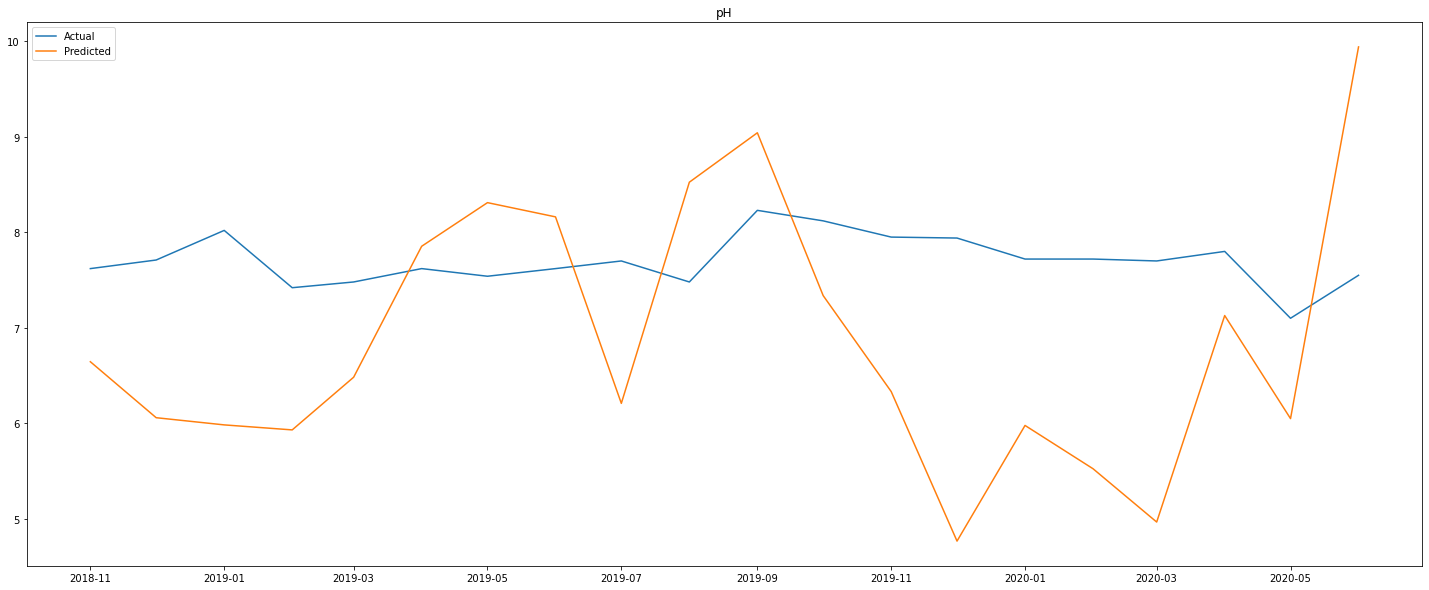

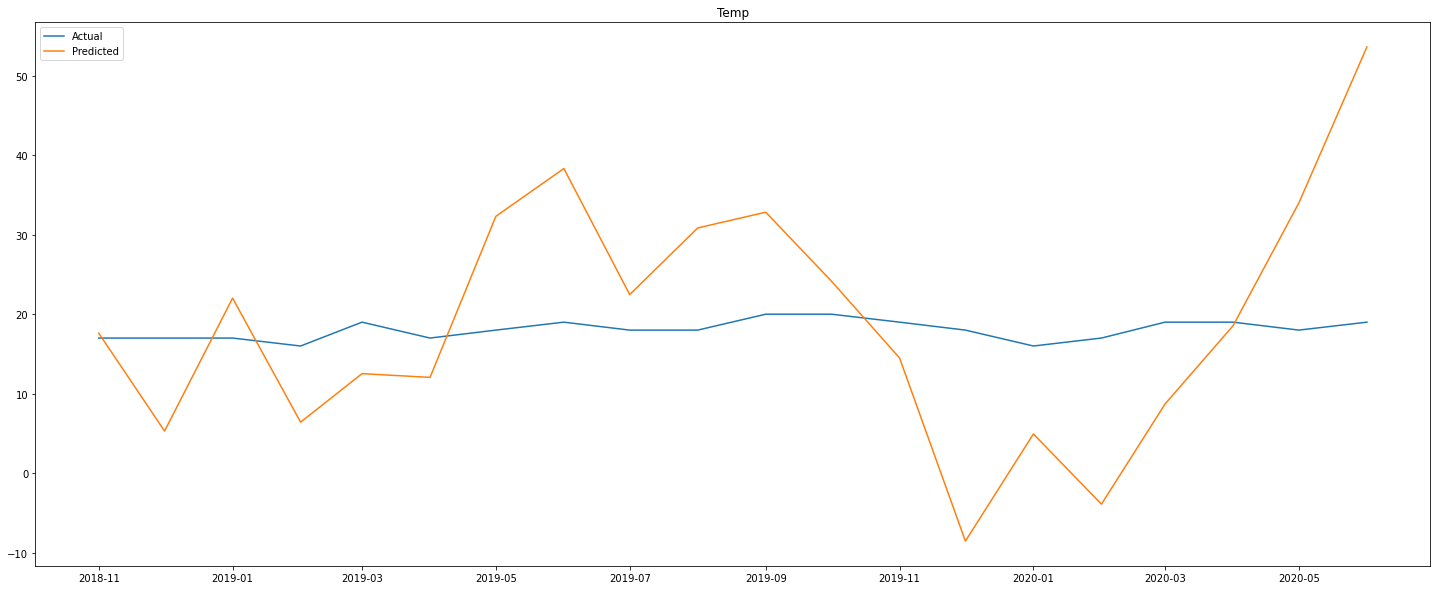

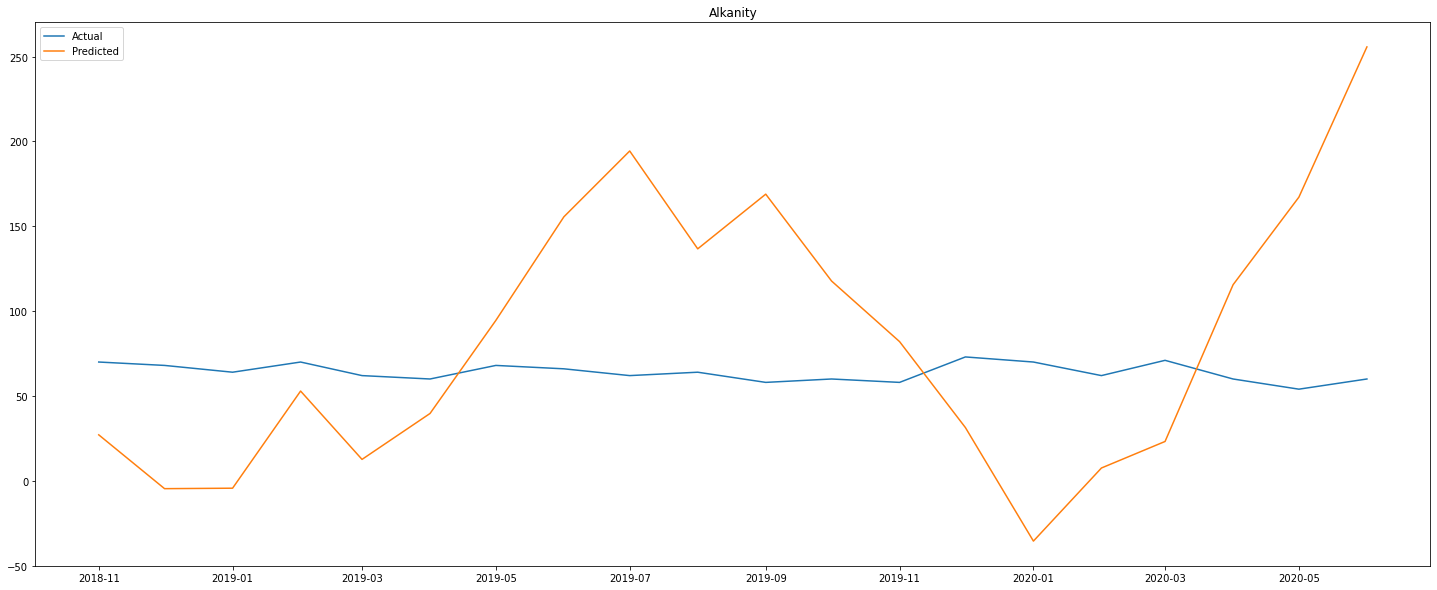

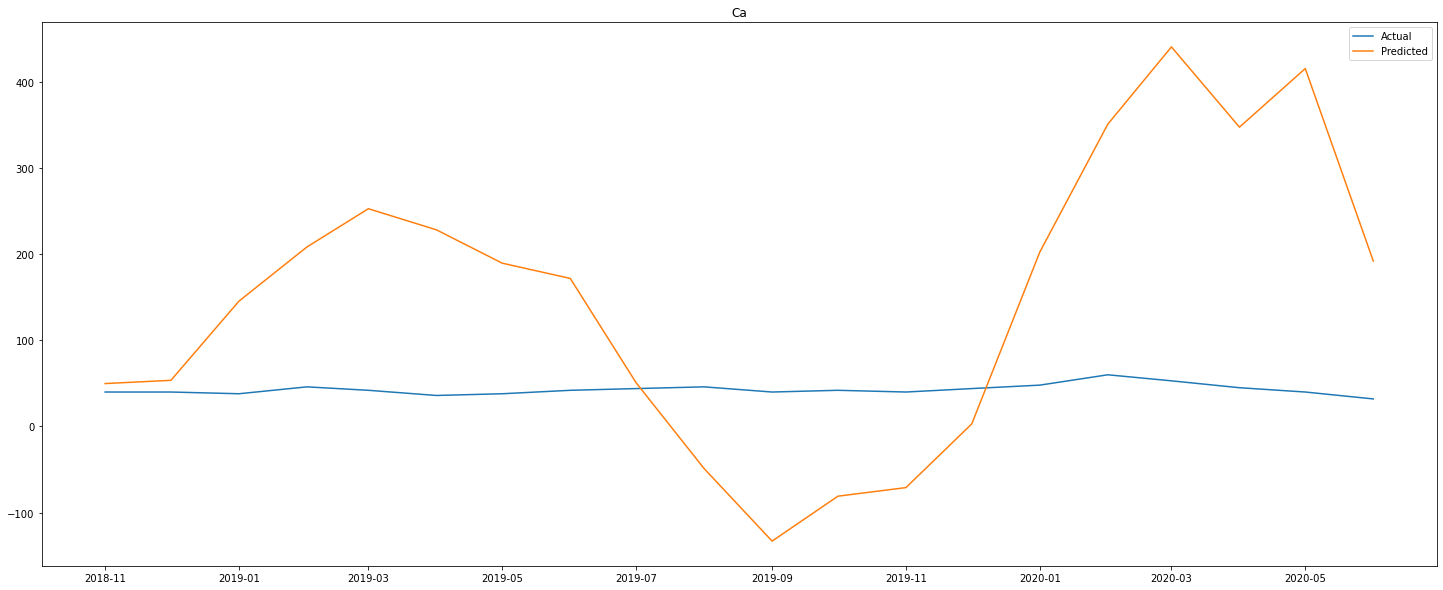

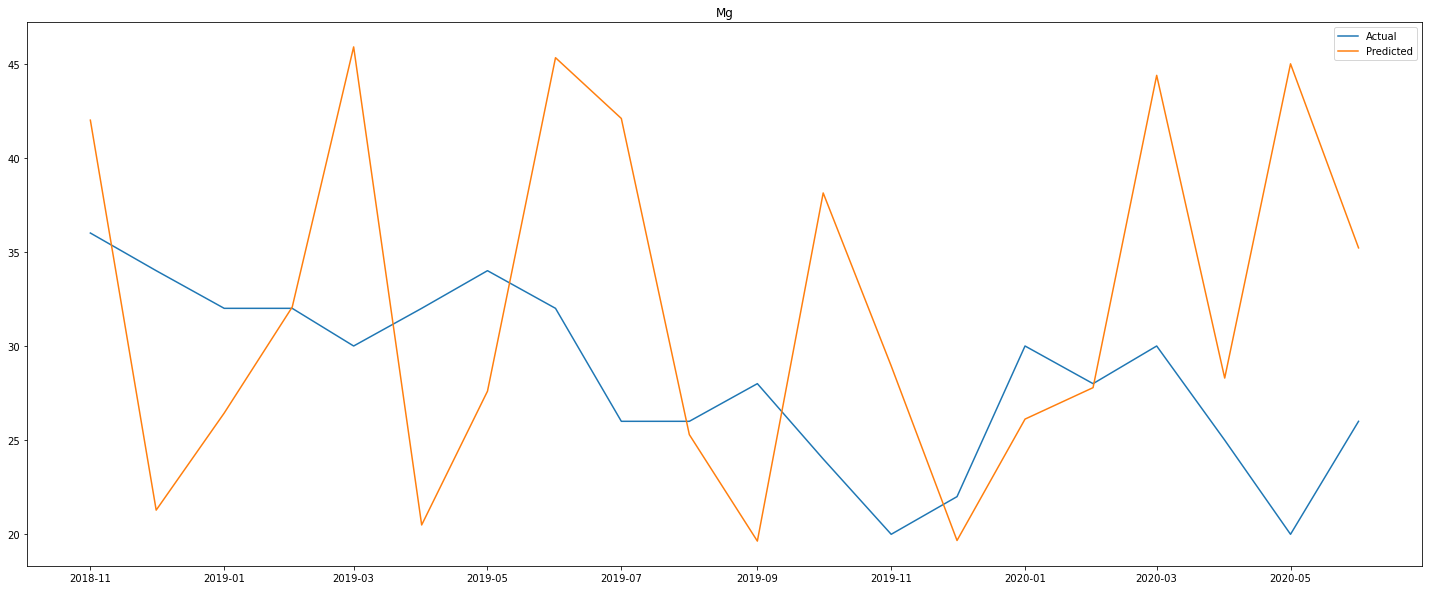

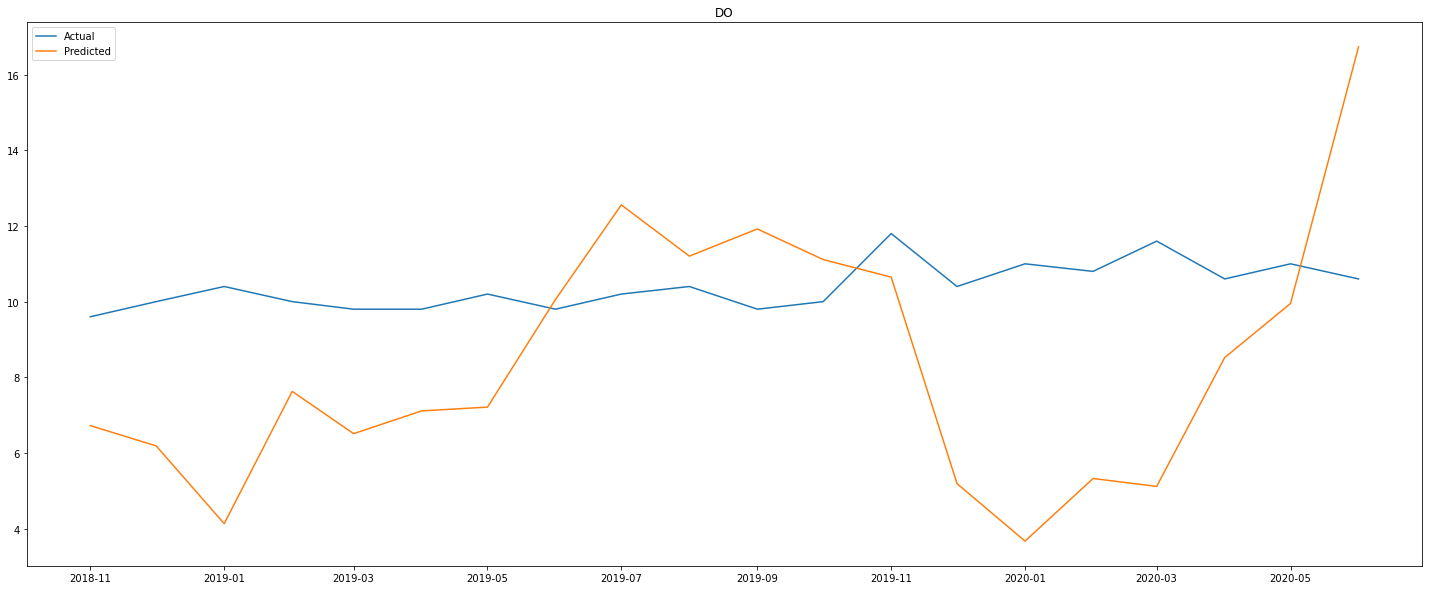

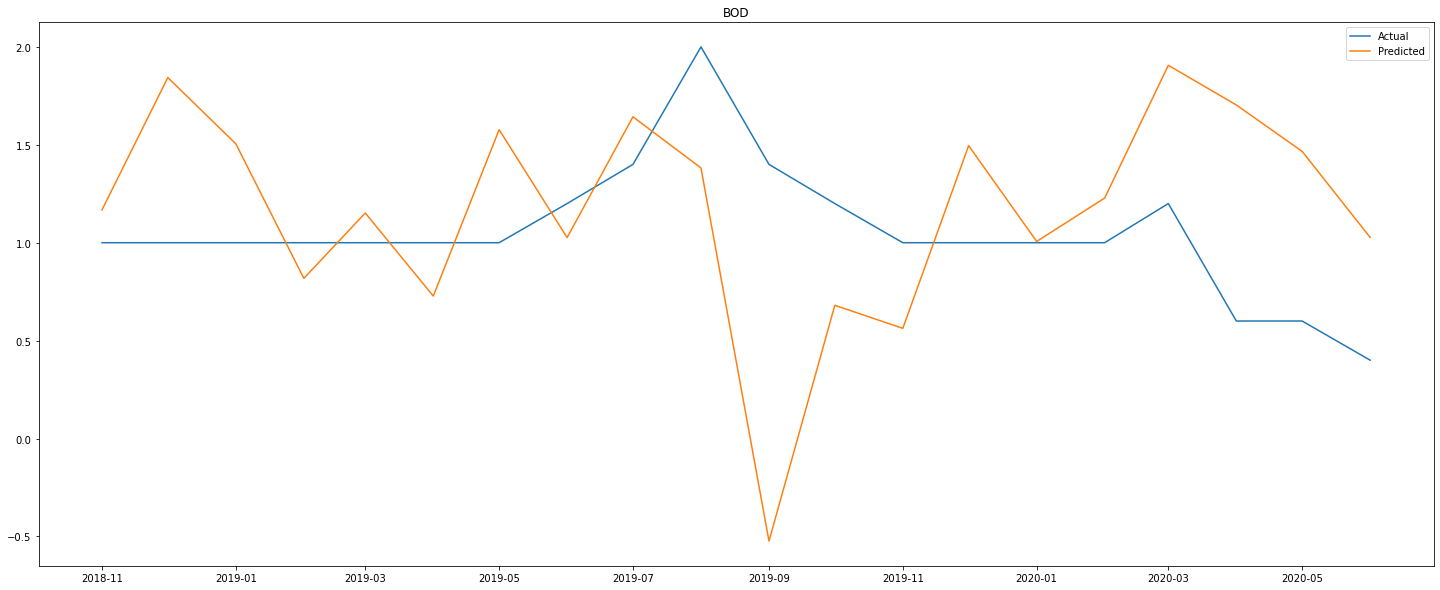

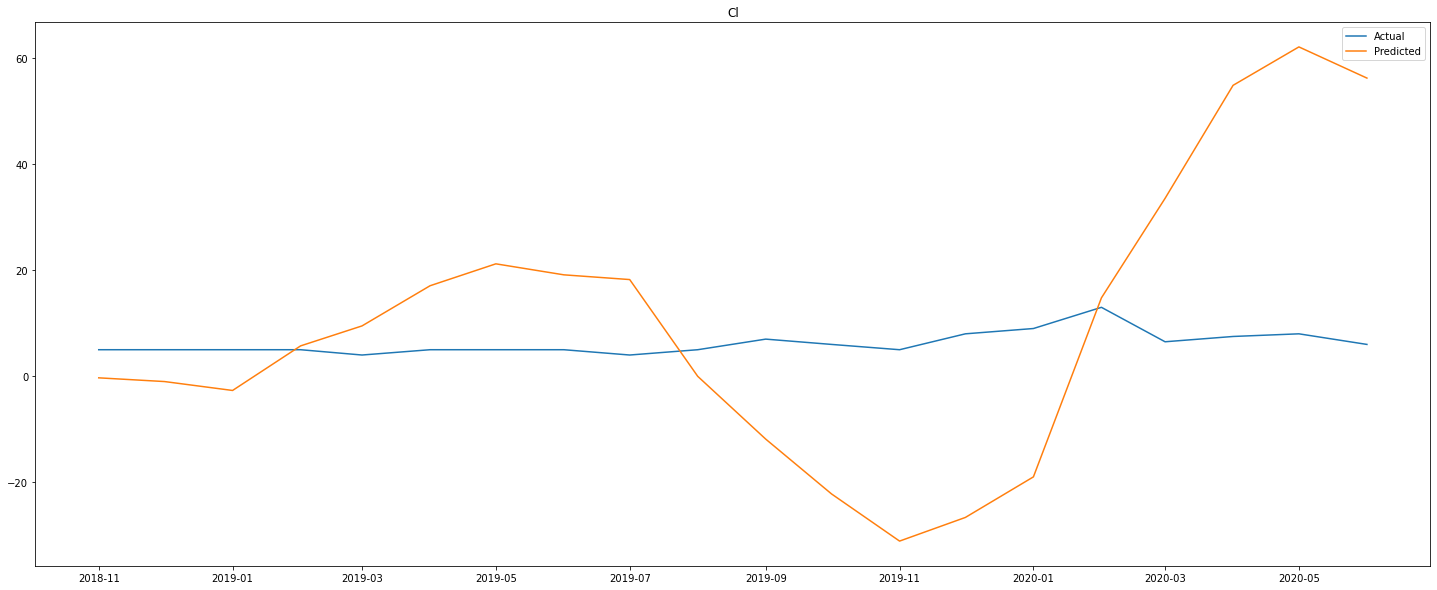

In [482]:
for i in lis:
        plt.figure(figsize = (25,10))
        plt.plot(X_test[i] , label = "Actual")
        plt.plot(output[i + '_pred'], label = "Predicted")
        plt.title(i)
        plt.legend(loc = 'best')
        plt.show()

#### Granger Causality test

Granger Causality tests try to determine if one variable(x1) can be used as a predictor of another variable(x2) where the past values of that another variable may or may not help

In [483]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=30

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(transformed_data[[r,c]], maxlag=maxlag, verbose=False) 
        #Check if time series in the second column Granger causes the time series in the first column
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var +'_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(dataset, variables = dataset.columns)  

,pH_x,Temp_x,Alkanity_x,Ca_x,Mg_x,DO_x,BOD_x,Cl_x
pH_y,1.0000,0.1194,0.0021,0.4703,0.3440,0.5336,0.0038,0.0822
Temp_y,0.0269,1.0000,0.0232,0.4660,0.0188,0.0000,0.2457,0.0006
Alkanity_y,0.0000,0.1464,1.0000,0.1605,0.0366,0.1170,0.0071,0.0000
Ca_y,0.3726,0.1148,0.0876,1.0000,0.0000,0.5603,0.0062,0.8184
Mg_y,0.2198,0.0092,0.0530,0.7919,1.0000,0.0000,0.0002,0.0796
DO_y,0.0027,0.0000,0.0006,0.3486,0.1826,1.0000,0.0000,0.0000
BOD_y,0.0000,0.6331,0.0000,0.0432,0.0001,0.0040,1.0000,0.0000
Cl_y,0.0000,0.0000,0.0000,0.4387,0.0962,0.0254,0.0000,1.0000


#### Combining VAR with LSTM

In [484]:
def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 10

def get_model():
    
    opt = RMSprop(lr=0.002)
    
    inp = Input(shape=(seq_length, 8))
    
    x = LSTM(64)(inp)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(8)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [485]:
best_order = 30
period = 1 #lag differenced period
X = results.fittedvalues
train_init = dataset.iloc[:len(X_train)-period,:].copy()
test_init = dataset.iloc[len(X_train)-period:-period,:].copy()

y_train = X_train.iloc[period+best_order:].values
y_train_var = X + train_init.iloc[best_order:].values
X_train = transformed_data.iloc[best_order:].values
X_train_var = X

y_val = y_train[int(len(X)*0.8):]
y_val_var = y_train_var[int(len(X)*0.8):]
X_val = X_train[int(len(X)*0.8):]
X_val_var = X_train_var[int(len(X)*0.8):]

y_train = y_train[:int(len(X)*0.8)]
y_train_var = y_train_var[:int(len(X)*0.8)]
X_train = X_train[:int(len(X)*0.8)]
X_train_var = X_train_var[:int(len(X)*0.8)]

y_test = X_test.values
test_diff = X_test.diff()
X_test = test_diff.values

In [486]:

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [487]:
generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=32)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=32)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)

In [488]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')
model_var = get_model()
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=100, validation_data=generator_val_var, validation_steps = len(generator_val_var), 
                        callbacks=[es], verbose = 1)


print('--------', 'train model with raw data', '--------')
model_var.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                        epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
Epoch 1/100
6/6 [==============================] - 1s 84ms/step - loss: 1.0324 - val_loss: 5.2212
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 0.9837 - val_loss: 5.2036
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.9268 - val_loss: 5.1906
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.9171 - val_loss: 5.1871
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8497 - val_loss: 5.1661
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.8687 - val_loss: 5.1462
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.8503 - val_loss: 5.1473
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 0.8421 - val_loss: 5.1295
Epoch 9/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7997 - val_loss: 5.1256
Epoch 10/100
6/6 [==============================] - 0s 12ms/step 

In [489]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

true = scaler_y.inverse_transform(y_test[seq_length:])

pred = model_var.predict_generator(generator_test)
pred = scaler_y.inverse_transform(pred)

In [490]:
### FIT NEURAL NETWORK WITH ONLY ORIGINAL DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

simple_model = get_model()
simple_model.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                            epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                            callbacks=[es], verbose = 1)

Epoch 1/100
6/6 [==============================] - 1s 88ms/step - loss: 1.0336 - val_loss: 5.2130
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.9950 - val_loss: 5.2004
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 0.9440 - val_loss: 5.1687
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.9386 - val_loss: 5.1642
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8781 - val_loss: 5.1525
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8971 - val_loss: 5.1273
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8767 - val_loss: 5.1177
Epoch 8/100
6/6 [==============================] - 0s 17ms/step - loss: 0.8760 - val_loss: 5.0863
Epoch 9/100
6/6 [==============================] - 0s 14ms/step - loss: 0.8366 - val_loss: 5.0772
Epoch 10/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8234 - val_loss: 5.0769
Epoch 11/100
6/6 [=

In [497]:
pred_simple = simple_model.predict_generator(generator_test)
pred_simple = scaler_y.inverse_transform(pred_simple)
pred_simple = np.nan_to_num(pred_simple)
pred = np.nan_to_num(pred)
diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}


for i,col in enumerate(dataset.columns):
    
    error = sqrt(mean_squared_error(true[:,i], pred_simple[:,i]))
    diz_error_lstm[col] = error
    error = sqrt(mean_squared_error(true[:,i], pred[:,i]))
    diz_error_var_lstm[col] = error

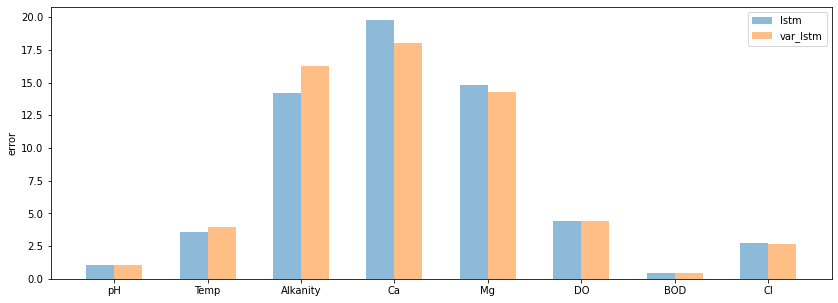

In [498]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('RMSE'); plt.legend()
np.set_printoptions(False)